In [12]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [13]:
actions = [
    'up',
    'left',
    'right',
    'down'
]

data = np.concatenate([
    np.load('dataset/seq_up_1634280272.npy'),
    np.load('dataset/seq_left_1634280272.npy'),
    np.load('dataset/seq_right_1634280272.npy'),
    np.load('dataset/seq_down_1634280272.npy')
], axis=0)

data.shape


(1909, 30, 100)

In [14]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1909, 30, 99)
(1909,)


In [15]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1909, 4)

In [16]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1718, 30, 99) (1718, 4)
(191, 30, 99) (191, 4)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                41984     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/turtlebot.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
54/54 [==============================] - 4s 36ms/step - loss: 39.9537 - acc: 0.3206 - val_loss: 30.4524 - val_acc: 0.4503

Epoch 00001: val_acc improved from -inf to 0.45026, saving model to models\turtlebot.h5
Epoch 2/200
54/54 [==============================] - 2s 29ms/step - loss: 23.1113 - acc: 0.5235 - val_loss: 15.0795 - val_acc: 0.5707

Epoch 00002: val_acc improved from 0.45026 to 0.57068, saving model to models\turtlebot.h5
Epoch 3/200
54/54 [==============================] - 2s 30ms/step - loss: 16.4408 - acc: 0.6447 - val_loss: 14.4066 - val_acc: 0.7225

Epoch 00003: val_acc improved from 0.57068 to 0.72251, saving model to models\turtlebot.h5
Epoch 4/200
54/54 [==============================] - 2s 30ms/step - loss: 13.1183 - acc: 0.6709 - val_loss: 8.3824 - val_acc: 0.5340

Epoch 00004: val_acc did not improve from 0.72251
Epoch 5/200
54/54 [==============================] - 2s 29ms/step - loss: 6.2215 - acc: 0.5922 - val_loss: 4.0770 - val_acc: 0.7592

Epoch 00

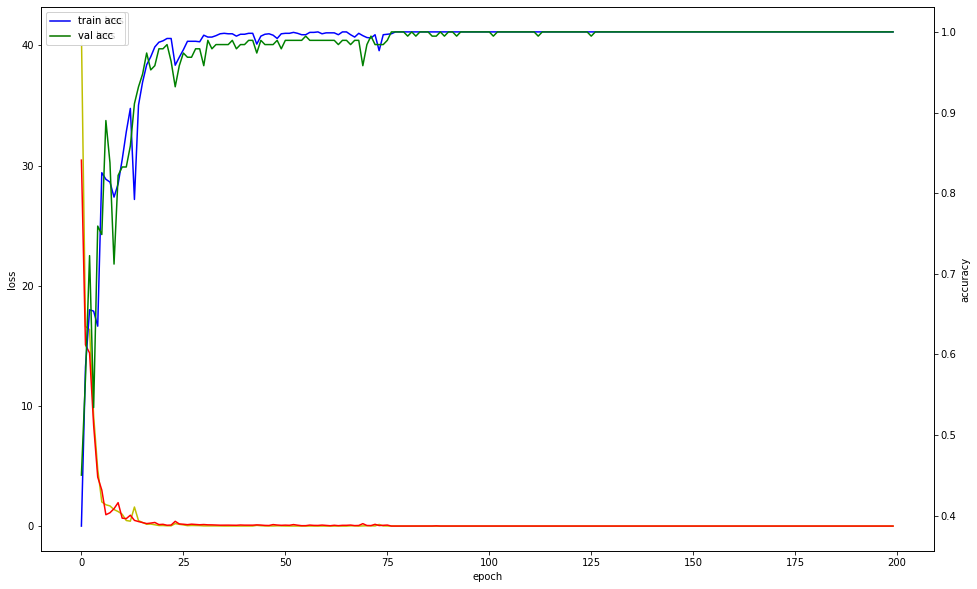

In [19]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [20]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[ 60,  90],
        [  3,  38]],

       [[128,   6],
        [ 53,   4]],

       [[109,  33],
        [ 29,  20]],

       [[147,   0],
        [ 44,   0]]], dtype=int64)